**Sources:**

The code is a further development of this preliminary project:

[1] https://github.com/bjorneme/preliminary/tree/main

The state-of-the-art model used as inspiration for multi-label classification on ChestX-ray14 is:

[2] https://github.com/syednabilashraf/SynthEnsemble/tree/main

The code used for TTA is:

[3] https://github.com/taheeraahmed/master-thesis

**Import Libraries**

In [24]:
# Standard Libraries
import os
import copy
import random
from glob import glob
from PIL import Image
import zipfile
import itertools

# Data Manipulation Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt

# Progress Bar
from tqdm import tqdm

# Machine Learning Libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, f1_score
from torch.amp import GradScaler, autocast

# Hugging Face transformers to load the MambaVision model
from transformers import AutoModel, AutoConfig, AutoModelForImageClassification, set_seed

# Import timm for models
import timm

**Define Parameters**

In [25]:
# Paths
ZIP_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14.zip'
EXTRACTED_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14-extracted'

# Disease labels
disease_labels = [
    'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
    'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
    'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
]

# Parameters
SEED = 42
NUM_WORKERS = 32
BATCH_SIZE = 32

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


**Set Seed for Reproducibility**

In [26]:
def seed_everything(seed=SEED):
    """
    Sets the seed to ensure reproducibility.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    set_seed(seed)

# Apply the seed
seed_everything()

# **Step 1: Load Data**

In [27]:
def extract_data(zip_path, extracted_path):
    """
    Extracts the ZIP file of the dataset.
    """
    os.makedirs(extracted_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)

# Extract ChestX-ray14 dataset
# TODO: Uncomment to extract data from zip
# extract_data(ZIP_PATH, EXTRACTED_PATH)

# **Step 2: Data Preprocessing**

In [28]:
def load_labels(csv_path, extracted_path):
    """
    Read labels from CSV, maps images to paths, and create binary disease labels.
    """

    # Read the CSV containing labels
    labels_df = pd.read_csv(csv_path)

    # Create binary columns for each disease label
    for disease in disease_labels:
        labels_df[disease] = labels_df['Finding Labels'].str.contains(disease).astype(int)

    # Create binary column for 'No Finding'
    labels_df['No Finding'] = labels_df['Finding Labels'].str.contains('No Finding').astype(int)

    # Map images to their full path
    labels_df['Path'] = labels_df['Image Index'].map(
        {os.path.basename(path): path for path in glob(os.path.join(extracted_path, '**', 'images', '*.png'))}
    )
    
    return labels_df

# Path to the labels CSV file
labels_csv_path = os.path.join(EXTRACTED_PATH, 'Data_Entry_2017.csv')

# Load and preprocess the labels
df = load_labels(labels_csv_path, EXTRACTED_PATH)

**Split Dataset**

In [29]:
# Split based on patients
unique_patients = df['Patient ID'].unique()

# Split patients into training, validation and test sets
train_val_patients, test_patients = train_test_split(
    unique_patients, test_size=0.2, random_state=SEED
)
train_patients, val_patients = train_test_split(
    train_val_patients, test_size=0.125, random_state=SEED
)

# Create dataframes for training, validation, and test sets
train_df = df[df['Patient ID'].isin(train_patients)].reset_index(drop=True)
val_df = df[df['Patient ID'].isin(val_patients)].reset_index(drop=True)
test_df = df[df['Patient ID'].isin(test_patients)].reset_index(drop=True)

# Verify Split Sizes
print(f"Train dataset size: {len(train_df)}. Number of unique patients: {len(train_patients)}")
print(f"Validation size: {len(val_df)}. Number of unique patients: {len(val_patients)}")
print(f"Test size: {len(test_df)}. Number of unique patients: {len(test_patients)}")

Train dataset size: 78614. Number of unique patients: 21563
Validation size: 11212. Number of unique patients: 3081
Test size: 22294. Number of unique patients: 6161


**Define Dataset for Chest X-ray images**

In [30]:
class ChestXrayDataset(Dataset):
    """
    Create dataset for Chest X-ray images.
    """
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        # Get image and labels
        img_path = self.df.iloc[idx]['Path']
        image = plt.imread(img_path)
        label = self.df.iloc[idx][disease_labels].values.astype(np.float32)
        
        # Apply transformation on image
        image = self.transform(image)
        
        return image, label

**Define Test Transformations**

In [31]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

# Define transformations for test data
test_transforms = transforms.Compose([

    # Convert image to PIL format
    transforms.ToPILImage(),

    # Convert to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 256x256
    transforms.Resize((256,256)),

    # Create 10 crops
    transforms.TenCrop(224),
    transforms.Lambda(lambda crops: torch.stack([
        transforms.ToTensor()(crop) for crop in crops
    ])),

    # Normalize using ImageNet mean and std
    transforms.Lambda(lambda crops: torch.stack(
        [transforms.Normalize(mean, std)(crop) for crop in crops]
    ))
])

**Create Test Dataset**

In [32]:
test_dataset = ChestXrayDataset(test_df, transform=test_transforms)

**Create Test DataLoader**

In [33]:
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# **Step 3: Build the Model**

In [34]:
# Dictionary to store all models
all_models = {}

**Load DenseNet121**

In [35]:
# Define the model
class MultiLabelClassifier(nn.Module):
    """
    Multi-Label Classification Model using DenseNet121 as the base model.
    """
    def __init__(self, device, num_classes=len(disease_labels)):
        super(MultiLabelClassifier, self).__init__()

        # Load pre-trained DenseNet121 model
        self.base_model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1).to((device)).to(device)

        # Replace the classification head to match the number of disease labels
        self.base_model.classifier= nn.Linear(self.base_model.classifier.in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

# Initialize the Model
densenet121_model = MultiLabelClassifier(device)
densenet121_model = nn.DataParallel(densenet121_model).to(device)

# Load the model
densenet121_model.load_state_dict(torch.load(
    '../ChestX-ray14 Single Models/DenseNet121/densenet121_byol_finetuning.pt',
    weights_only=True
))

all_models['DenseNet121'] = densenet121_model

**Load MambaVision L**

In [36]:
# Define the model
class MultiLabelClassifier(nn.Module):
    """
    Multi-Label Classification Model using MambaVision as the base model.
    """
    def __init__(self, device, model_name="nvidia/MambaVision-T2-1K", num_classes=len(disease_labels)):
        super(MultiLabelClassifier, self).__init__()

        # Load pre-trained MambaVision model
        self.base_model = AutoModel.from_pretrained(model_name, trust_remote_code=True).to(device)

        # Replace the classification head to match the number of disease labels
        self.base_model.model.head = nn.Linear(self.base_model.model.head.in_features, num_classes)

    def forward(self, x):
        avg_pool, _ = self.base_model(x)
        return self.base_model.model.head(avg_pool)

# Initialize the Model
mambavision_L_model = MultiLabelClassifier(device, "nvidia/MambaVision-L-21K")
mambavision_L_model = nn.DataParallel(mambavision_L_model).to(device)

# Load the model
mambavision_L_model.load_state_dict(torch.load(
    '../ChestX-ray14 Single Models/MambaVision_Large/mambavision_L_byol_finetuning.pt',
    weights_only=True
))

all_models['MambaVision L'] = mambavision_L_model

**Load CoAtNet**

In [37]:
# Define the model
class MultiLabelClassifier(nn.Module):
    """
    Multi-Label Classification Model using CoAtNet as the base model.
    """
    def __init__(self, device, model_name, num_classes=len(disease_labels)):
        super(MultiLabelClassifier, self).__init__()

        # Load pre-trained CoAtNet model
        self.base_model = timm.create_model(model_name, pretrained=True).to(device)

        # Replace the classification head to match the number of disease labels
        self.base_model.head.fc = nn.Linear(self.base_model.head.fc.in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

# Initialize the Model
coatnet_model = MultiLabelClassifier(device, "coatnet_2_rw_224.sw_in12k_ft_in1k")
coatnet_model = nn.DataParallel(coatnet_model).to(device)

# Load the model
coatnet_model.load_state_dict(torch.load(
    '../ChestX-ray14 Single Models/CoAtNet/coatnet_tta_backbone.pt',
    weights_only=True
))

all_models['CoAtNet'] = coatnet_model

**Import ConvNeXt v2**

In [38]:
# Define the model
class MultiLabelClassifier(nn.Module):
    """
    Multi-Label Classification Model using ConvNeXt v2 as the base model.
    """
    def __init__(self, device, model_name, num_classes=len(disease_labels)):
        super(MultiLabelClassifier, self).__init__()

        # Load pre-trained ConvNeXt v2 model
        self.base_model = timm.create_model(model_name, pretrained=True).to(device)

        # Replace the classification head to match the number of disease labels
        self.base_model.head.fc = nn.Linear(self.base_model.head.fc.in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

# Initialize the Model
convnext_v2_model = MultiLabelClassifier(device, "convnextv2_large.fcmae_ft_in22k_in1k")
convnext_v2_model = nn.DataParallel(convnext_v2_model).to(device)

# Load the model
convnext_v2_model.load_state_dict(torch.load(
    '../ChestX-ray14 Single Models/ConvNeXt_v2/convnext_v2_tta_backbone.pt',
    weights_only=True
))

all_models['ConvNeXt v2'] = convnext_v2_model

**Load MaxViT**

In [39]:
# Define the model
class MultiLabelClassifier(nn.Module):
    """
    Multi-Label Classification Model using MaxViT as the base model.
    """
    def __init__(self, device, model_name, num_classes=len(disease_labels)):
        super(MultiLabelClassifier, self).__init__()

        # Load pre-trained MaxViT model
        self.base_model = timm.create_model(model_name, pretrained=True).to(device)

        # Replace the classification head to match the number of disease labels
        self.base_model.head.fc = nn.Linear(self.base_model.head.fc.in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

# Initialize the Model
maxvit_model = MultiLabelClassifier(device, "maxxvitv2_rmlp_base_rw_224.sw_in12k_ft_in1k")
maxvit_model = nn.DataParallel(maxvit_model).to(device)

# Load the model
maxvit_model.load_state_dict(torch.load(
    '../ChestX-ray14 Single Models/MaxViT/maxvit_byol_finetuning.pt',
    weights_only=True
))

all_models['MaxViT'] = maxvit_model

**Load Swin v2**

In [40]:
# Define the model
class MultiLabelClassifier(nn.Module):
    """
    Multi-Label Classification Model using Swin v2 as the base model.
    """
    def __init__(self, device, model_name, num_classes=len(disease_labels)):
        super(MultiLabelClassifier, self).__init__()

        # Load pre-trained Swin v2 model
        self.base_model = timm.create_model(model_name, pretrained=True).to(device)

        # Replace the classification head to match the number of disease labels
        self.base_model.head.fc = nn.Linear(self.base_model.head.fc.in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

# Initialize the Model
swin_v2_model = MultiLabelClassifier(device, "swinv2_cr_small_ns_224.sw_in1k")
swin_v2_model = nn.DataParallel(swin_v2_model).to(device)

# Load the model
swin_v2_model.load_state_dict(torch.load(
    '../ChestX-ray14 Single Models/Swin_v2/swin_v2_byol_finetuning.pt',
    weights_only=True
))

all_models['Swin v2'] = swin_v2_model

**Load VMamba**

In [41]:
# Define the model
class MultiLabelClassifier(nn.Module):
    """
    Multi-Label Classification Model using Vision Mamba as the base model.
    """
    def __init__(self, device, model_name, num_classes=len(disease_labels)):
        super(MultiLabelClassifier, self).__init__()

        # Load pre-trained Vision Mamba model
        self.base_model = AutoModelForImageClassification.from_pretrained(model_name,trust_remote_code=True).to(device)

        # Replace the classification head to match the number of disease labels
        self.base_model.head = nn.Linear(self.base_model.head.in_features, num_classes)

    def forward(self, x):
        return self.base_model(x).logits

# Initialize the Model
vmamba_model = MultiLabelClassifier(device, "saurabhati/VMamba_ImageNet_83.6")
vmamba_model = nn.DataParallel(vmamba_model).to(device)

# Load the model
vmamba_model.load_state_dict(torch.load(
    '../ChestX-ray14 Single Models/VMamba/vmamba_tta_backbone.pt',
    weights_only=True
))

all_models['VMamba'] = vmamba_model

# **Step 4: Evaluate the Model**

In [42]:
def evaluate_model(model, test_loader, model_name):
    """
    Evaluate the model on the test set.
    """

    # Store all predictions
    all_preds = []
    all_labels = []

    # Progress bar
    progress_bar = tqdm(test_loader, desc=f"Evaluating {model_name} on Test Set")

    # Set to evaluation mode
    model.eval()

    # Disable gradients for evaluation
    with torch.no_grad():
        for inputs, labels in progress_bar:
            # Retrieve input sizes
            batch_size, ncrops, C, H, W = inputs.size()

            # Move to device
            inputs, labels = inputs.to(device), labels.to(device)

            # Change to [batch_size * ncrops, C, H, W]
            inputs = inputs.view(-1, C, H, W)  

            # Forward pass
            outputs = model(inputs)

            # Change to [batch_size * ncrops, C, H, W] and average
            outputs = outputs.view(batch_size, ncrops, -1).mean(1)

            # Apply sigmoid
            predictions = torch.sigmoid(outputs)

            # Store predictions and true labels
            all_preds.append(predictions.cpu())
            all_labels.append(labels.cpu())

    # Concatenate all batches
    predictions = torch.cat(all_preds)
    labels = torch.cat(all_labels)
    
    return predictions, labels

**Evaluate all Models on the Test Set**

In [43]:
def evaluate_all_models(all_models, test_loader):
    """
    Do the evaluation loop on all models.
    """

    # Dictionaries for storing predictions. Do also store labels
    predictions_dict = {}
    labels_dict = {}

    # Evaluate all models
    for model_name, model in all_models.items():

        # Retrive predictions and true labels
        predictions, labels = evaluate_model(model, test_loader, model_name)

        # Save predictions and labels
        predictions_dict[model_name] = predictions
        labels_dict[model_name] = labels

        print()

    return predictions_dict, labels_dict

# Evaluate all models
predictions_dict, labels_dict = evaluate_all_models(all_models, test_loader)

Evaluating DenseNet121 on Test Set:   0%|          | 0/697 [00:00<?, ?it/s]

Evaluating DenseNet121 on Test Set: 100%|██████████| 697/697 [01:22<00:00,  8.48it/s]


Evaluating MambaVision L on Test Set: 100%|██████████| 697/697 [05:32<00:00,  2.10it/s]


Evaluating CoAtNet on Test Set: 100%|██████████| 697/697 [02:57<00:00,  3.92it/s]


Evaluating ConvNeXt v2 on Test Set: 100%|██████████| 697/697 [07:55<00:00,  1.47it/s]


Evaluating MaxViT on Test Set: 100%|██████████| 697/697 [04:58<00:00,  2.34it/s]


Evaluating Swin v2 on Test Set: 100%|██████████| 697/697 [03:08<00:00,  3.70it/s]


Evaluating VMamba on Test Set: 100%|██████████| 697/697 [05:19<00:00,  2.18it/s]

**Find the Best Combination of Ensembles**

In [44]:
def find_best_model(predictions_dict, labels_dict):
    """
    Search for the best combination of models.
    """

    best_auc = 0
    metric_df_best_combination = None
    best_model_combination = None

    # Model names
    model_names = list(predictions_dict.keys())

    # Find model combinations
    all_combinations = []
    for i in range(1, len(model_names)+1):
        for combination in itertools.combinations(model_names, i):
            all_combinations.append(combination)

    # Progress bar
    progress_bar = tqdm(all_combinations, desc=f"Searching for the best combination")
    
    # Iterate over all model combinations
    for combination in progress_bar:

        # Dictionaries for storing metrics
        accuracy_per_label, f1_score_per_label, mean_auc_per_label = {}, {}, {}

        # Aggreage predictions for all models
        ensemble_pred = 0
        for model_name in combination:
            ensemble_pred += predictions_dict[model_name]
        predictions = ensemble_pred/ len(combination)

        # Compute metrics for each label
        for i, label in enumerate(disease_labels):

            # Retrieve labels
            labels = labels_dict[model_name]

            # Create binary predictions
            binary_predictions = predictions[:, i] > 0.5

            # Calculate accuracy
            accuracy_per_label[label] = accuracy_score(labels[:, i], binary_predictions)

            # Calculate f1 score
            f1_score_per_label[label] = f1_score(labels[:, i], binary_predictions, average='macro')

            # Calculate mAUC
            mean_auc_per_label[label] = roc_auc_score(labels[:, i], predictions[:, i])

        # Create a df with metrics
        metrics_df = pd.DataFrame({
            'Accuracy': accuracy_per_label,
            'F1 Score': f1_score_per_label,
            'mAUC': mean_auc_per_label
        })

        # Calculate the mean for all diseases
        metrics_df.loc['Overall'] = metrics_df.mean()

        # Save if mAUC is higher
        if metrics_df.loc['Overall']['mAUC'] > best_auc:
            metric_df_best_combination = metrics_df
            best_model_combination = combination
            best_auc = metrics_df.loc['Overall']['mAUC']
            best_predictions = predictions
            best_labels = labels
            best_mean_auc_per_label = mean_auc_per_label

            # Print model combination and mAUC
            print(f"New best combination: {combination}, mAUC: {metrics_df.loc['Overall']['mAUC']:.4f}")
        
    # Return the metric for the best model
    return metric_df_best_combination, best_model_combination, best_predictions, best_labels, best_mean_auc_per_label

metric_df_best_combination, best_model_combination, predictions, labels, mean_auc_per_label = find_best_model(predictions_dict, labels_dict)

Searching for the best combination:   1%|          | 1/127 [00:00<00:18,  6.79it/s]

New best combination: ('DenseNet121',), mAUC: 0.8481


Searching for the best combination:   2%|▏         | 2/127 [00:00<00:16,  7.63it/s]

New best combination: ('MambaVision L',), mAUC: 0.8530


Searching for the best combination:   7%|▋         | 9/127 [00:01<00:13,  8.44it/s]

New best combination: ('DenseNet121', 'MambaVision L'), mAUC: 0.8568


Searching for the best combination:  12%|█▏        | 15/127 [00:01<00:13,  8.32it/s]

New best combination: ('MambaVision L', 'CoAtNet'), mAUC: 0.8577


Searching for the best combination:  24%|██▎       | 30/127 [00:03<00:11,  8.44it/s]

New best combination: ('DenseNet121', 'MambaVision L', 'CoAtNet'), mAUC: 0.8591


Searching for the best combination:  36%|███▌      | 46/127 [00:05<00:09,  8.39it/s]

New best combination: ('MambaVision L', 'CoAtNet', 'MaxViT'), mAUC: 0.8593


Searching for the best combination:  38%|███▊      | 48/127 [00:05<00:09,  8.38it/s]

New best combination: ('MambaVision L', 'CoAtNet', 'VMamba'), mAUC: 0.8593


Searching for the best combination:  52%|█████▏    | 66/127 [00:07<00:07,  8.39it/s]

New best combination: ('DenseNet121', 'MambaVision L', 'CoAtNet', 'MaxViT'), mAUC: 0.8600


Searching for the best combination:  54%|█████▎    | 68/127 [00:08<00:07,  8.39it/s]

New best combination: ('DenseNet121', 'MambaVision L', 'CoAtNet', 'VMamba'), mAUC: 0.8600


Searching for the best combination:  70%|███████   | 89/127 [00:10<00:04,  8.40it/s]

New best combination: ('MambaVision L', 'CoAtNet', 'MaxViT', 'VMamba'), mAUC: 0.8601


Searching for the best combination:  82%|████████▏ | 104/127 [00:12<00:02,  8.40it/s]

New best combination: ('DenseNet121', 'MambaVision L', 'CoAtNet', 'MaxViT', 'VMamba'), mAUC: 0.8606


Searching for the best combination: 100%|██████████| 127/127 [00:15<00:00,  8.39it/s]


**Print Results Best Combination**

In [45]:
print(best_model_combination)
metric_df_best_combination

('DenseNet121', 'MambaVision L', 'CoAtNet', 'MaxViT', 'VMamba')


,Accuracy,F1 Score,mAUC
Atelectasis,0.905535,0.598997,0.842558
Consolidation,0.957298,0.493256,0.835178
Infiltration,0.814390,0.553457,0.725008
Pneumothorax,0.955952,0.623861,0.899327
Edema,0.978963,0.509176,0.901742
Emphysema,0.976092,0.633300,0.942245
Fibrosis,0.983493,0.501215,0.833560
Effusion,0.902395,0.702800,0.892039
Pneumonia,0.986813,0.496681,0.770492
Pleural_Thickening,0.970261,0.501340,0.823727


**Plot ROC curves for each Label**

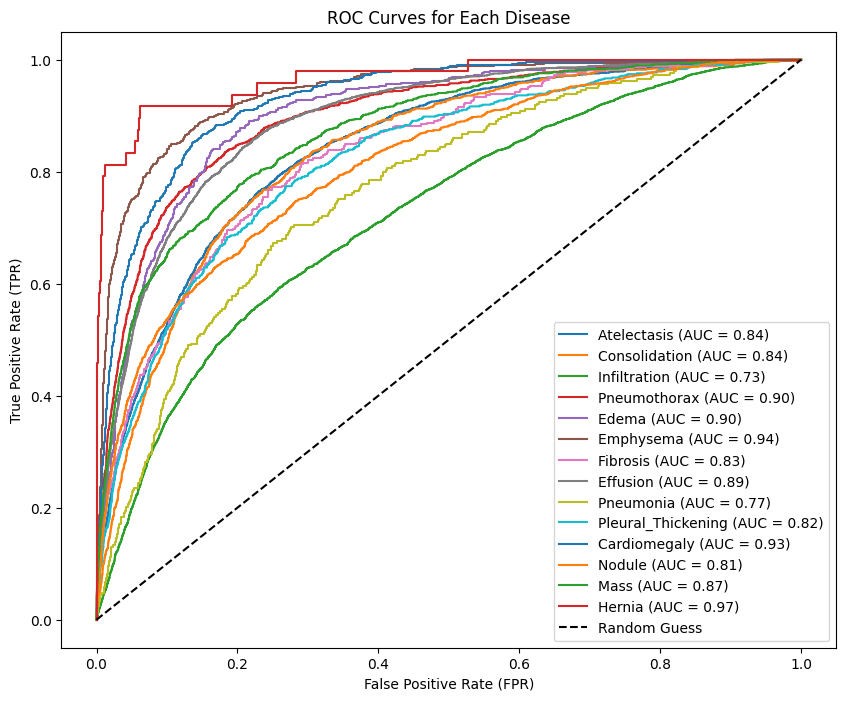

In [46]:
plt.figure(figsize=(10, 8))
for i, label in enumerate(disease_labels):
    fpr, tpr, _ = roc_curve(labels[:, i], predictions[:, i])
    plt.plot(fpr, tpr, label=f"{label} (AUC = {mean_auc_per_label[label]:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='black', label="Random Guess")
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curves for Each Disease')
plt.legend(loc='lower right')
plt.show()